# Péndulo invertido en un carro

Carlos Ruestes, Cristián Sanchez
</section>
Última edición: Noviembre de 2020

___

## Introducción
El péndulo invertido es un ejemplo clásico en problemas de control. Todos hemos intentado, alguna vez, balancear una escoba o un palo en forma vertical sobre la palma de una mano. En este notebook, intentarán balancear un péndulo invertido sobre un carro sujeto a una fuerza externa que actúa en el centro de masa del carro.

<a id="img1" title="Oppenheim">
<img width=600 src="imagesInvPend/Oppenheim.png"></a>

**Figura 1:** Alan V. Oppenheim (Profesor MIT) en su clase *The Inverted Pendulum* del curso *Signals and Systems*. Fuente: Notas de clase de Oppenheim [[1]].

La figura de arriba muestra una configuración experimental común para controlar un péndulo invertido. El péndulo se mueve tirando de un cable suspendido entre el carro y un motor eléctrico. En este caso en particular, el controlador balanceará al péndulo independientemente de la masa del péndulo, lo cual explica la postura confiada del profesor al agregar líquido en el vaso. 

Inicialmente, modelaremos nuestro péndulo usando mecánica lagrangiana y luego controlaremos el péndulo usando control proporcional. 

In [27]:
import numpy as np
#import progressbar
#from ipy_progressbar import ProgressBar
from jupyter_progressbar import ProgressBar
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
from scipy import signal
%matplotlib inline

## Teoría, Parte I
La figure 2 muestra un esquema del sistema usado en este ejemplo. El péndulo invertido se fija sobre el carrito en uno de sus extremos y tiene una masa $M$. Se asume que la rotación en el punto de fijación es libre de fricción. La bolita en el extremo del péndulo tiene una masa $m$, mientras que la vara rígida que conecta la bolita con el carro no tiene masa. El carro se puede mover respecto a la superficie en la dirección $x$. Las ruedas se incluyen a modo ilustrativo. La fuerza que actúa en la bolita es la fuerza gravitatoria conservativa $\vec{G}$ en la dirección $y$ con sentido negativo, mientras que la fuerza actuante en el carrito es la fuerza external aplicada $\vec{u}$ en la dirección $x$. La fuerza $\vec{F}$ es una aproximación a la fricción del sistema completo, y actúa también en la dirección $x$. La longitud de la vara es $l$, y el desplazamiento angular del péndulo relativo a $\vec{y}$ esta dado por $\theta$.

<a id="img2" title="Esquema de pendulo invertido sobre un carro">
    
<img width=400 alt ="schematic"
src="imagesInvPend/drawing.png" ></a>

**Figura 2:** *Esquema de péndulo invertido. El ángulo $\theta$ de la bolita es cero en la posición vertical (equilibrio inestable).

In [28]:
figSizeX = 12
figSizeY = 9

# Parametros del sistema
m = 0.1          # masa de la bolita  [kg]
M = 1            # masa del carro  [kg]
l = 0.2          # largo de la vara [m]
g = 9.81         # g [m s^-2]
mu = 10          # coeficiente de friccion [kg s^-1]

# Condiciones iniciales de las coordenadas generalizadas
x0_0 = 0         # posicion del carro [m]
x1_0 = 0         # angulo de la vara [radians]
x2_0 = 0         # velocidad del carro [m s^-1]
x3_0 = 0         # velocidad angular de la vara [radians s^-1]
u_0 = 0          # fuerza inicial del carro  [kg m s^-2]

Pueden probar alterando los parámetros del sistema para obtener distintos movimientos y respuesta del sistema. Por ejemplo, una bolita de mayor masa acarrea la necesidad de una fuerza externa mayor para lograr el balanceo, y una vara más larga produce una disminución en el período de oscilación del péndulo.

### Ecuaciones de movimiento
Es posible obtener las ecuaciones de movimiento usando ecuaciones de Newton tipo F=m*a, pero la formulación lagrangiana es más elegante. El desarrollo completo para obtener las ecuaciones está a partir del Lagrangiano $$ L = T - U $$ 
se presenta en el [apéndice A](#apndxA).

El sistema correspondiente a la [figura 2](#img2) tiene dos restricciones holonómicas: El largo de la vara $l$ es fijo, y la coordenada $y$ del carro es siempre cero. Esto resulta en dos coordenadas generalizadas: El ángulo de la bolita $\theta$, la posición del carro $x$ y sus derivadas temporales $\dot{\theta}$ y $\dot{x}$. Las ecuaciones de movimiento resultan

\begin{equation}
    \ddot{x} = \lambda(\theta)\big[mgl^2\dot{\theta}^2\sin\theta - mgl \sin\theta \cos\theta - l\mu \dot{x} + ul \big]
\label{cartacc}
\end{equation}

\begin{equation}
        \ddot{\theta} = \lambda(\theta)\big[(m + M)g \sin\theta - mgl\dot{\theta}^2 \sin\theta \cos\theta +  \mu\dot{x}\cos\theta - u\cos\theta \big]
\label{angelacc}
\end{equation}

donde

\begin{equation}
    \lambda(\theta) = \frac{1}{l(M + m\sin^2\theta)}
\label{lambda} \text{.}
\end{equation}

El coeficiente de fricción $\mu$ se origina a partir de la fuerza de fricción $\vec{F}$, que es proporcional a la velocidad del carro, $F = -\mu\dot{x}$.

Renombrando las coordenadas generalizadas, obtenemos el *vector de estados*:

\begin{equation}
\textbf{x} =
\begin{bmatrix} x_0 \\
                x_1 \\
                x_2 \\
                x_3
\end{bmatrix} = 
\begin{bmatrix} x \\
                \theta \\
                \dot{x} \\
                \dot{\theta}
\end{bmatrix} \text{.}
\end{equation}

Luego, dandonos cuenta que $\dot{x_0} = x_2$ y $\dot{x_1} = x_3$, obtenemos una *ecuación de estado*:

\begin{equation}
    \dot{\textbf{x}} = \frac{d}{dt}
    \begin{bmatrix} x_0 \\
                    x_1 \\
                    x_2 \\
                    x_3
    \end{bmatrix} = 
    \begin{bmatrix} x_2 \\
                    x_3 \\
                    \lambda(x_1)\big[ml^2{x_3}^2\sin x_1 - mgl \sin x_1 \cos x_1 - l\mu x_2 + ul \big] \\
                    \lambda(x_1)\big[(m + M)g \sin x_1 - ml{x_3}^2 \sin x_1 \cos x_1 +  \mu x_2\cos x_1 - u\cos x_1 \big]
    \end{bmatrix} \text{.}
\label{stateEquation}
\end{equation}

Las últimas dos ecuaciones en el vector de estado son no lineales. Esto quiere decir que es muy difícil regular el movimiento del sistema. En consecuencia deberemos linealizarlo. Esto se hace en la parte II del notebook.

## Implementación - Parte I
### Simulando el sistema

La simulación del péndulo invertido en un carro se realiza en forma iterativa, usando *Runge Kutta de 4to orden*.

Además de definir la función RK4, definimos una función que devuelve el lado derecho de \eqref{stateEquation} dado un vector $\textbf{x}$ y los parámetros del sistema, y una función para calcular la energía potencial y cinética del sistema. 

In [34]:
def RHS(z, RHSargs): 
        """Dados vector de estado, parametros del sistema,
        z y RHSargs respectivamente, esta funcion devuelve la derivada 
        temporal de los elementos del vector de estado, es decir, el lado
        derecho de las ecuaciones de estado.
        Parametros:
            z        4x1 array
            RHSargs  6x1 array
        Devuelve:
            dxdt     4x1 array
        """
        m, M, l, g, mu, u = RHSargs
        x0, x1, x2, x3 = z
        dx0dt = x2
        dx1dt = x3
        lambdax1 = 1/(l*(M + m*np.sin(x1)**2))
        
        dx2dt = lambdax1*(m*l*l*x3**2*np.sin(x1) - m*g*l*np.sin(x1)*np.cos(x1)
                            - l*mu*x2  + u*l)
        dx3dt = lambdax1*((m + M)*g*np.sin(x1) - m*l*x3*x3*np.sin(x1)*np.cos(x1)
                            + mu*x2*np.cos(x1) - u*np.cos(x1))
        
        dxdt = np.array([dx0dt, dx1dt, dx2dt, dx3dt])
                               
        return dxdt
                               

def RK4Step(z, dt, RHS, RHSargs):
        """ Realiza un paso de Runge Kutta cuarto orden
        z el el vector de estado actual, dt es el paso temporal, 
        RHS es la f para el lado derecho del sistema de Ec.Dif., y RHSargs 
        son los parametros de entrada para esa funcion. RK4step devuelve el siguiente
        vector de estado, es decir, los valores de z luego de un tiempo dt.
        Parametros:
            z         4x1 array
            dt        float
            RHS       function
            RHSargs   6x1 array
        Devuelve:
            el vector de estado, z, luego de un tiempo, dt.
        """
        k1 = np.array(RHS(z, RHSargs))
        k2 = np.array(RHS(z + k1*dt/2, RHSargs))
        k3 = np.array(RHS(z + k2*dt/2, RHSargs))
        k4 = np.array(RHS(z + k3*dt, RHSargs))
        
        return z + dt/6*(k1 + 2*k2 + 2*k3 + k4)

In [35]:
def addEnergy(z):
    """ Dado el vector de estado, z, calcula y devuelve la energia cinetica
    y potencial del sistema en un array. Ver apendice B para los terminos de 
    las formuals de energia.
    """
    x0, x1, x2, x3 = z
    U = m*g*l*np.cos(x1)
    T = 0.5*x2**2*(m + M) + 0.5*m*x3**2*l**2 + m*x2*x3*l*np.cos(x1)
    return np.array([T, U])

Ahora podemos integrar la ecuación de estado luego de definir un paso temporal, $\Delta t$, y la duración de todo el proceso de integración $t_{max}$. La matriz ``Z`` se inicializa para contener el vector de estado a cualquier tiempo $t$. Mientras que el ángulo inicial del péndulo es cero, nunca se caerá pq la componente x de la fuerza gravitatoria es cero. Entonces para hacer la situación más realista, se agrega un ruido en forma de fuerza externa, $u$, en cada iteración. El ruido podría corresponder, por ejemplo, a corrientes de aire en el entorno del sistema.

In [36]:
duration = 10                # Tiempo de integracion [seg]
timeStep = 1e-2              # paso temporal 
n = int(duration/timeStep)   # numero de puntos

# inicializando matrices
RHSargs = np.array([m, M, l, g, mu, u_0]) # Parametros del sistema
Z = np.zeros((4, n))                      # Z = [[x0_0, ... x0_n], [x1_0, ... x1_n], [x2,...,], [x3,...,]
# Insertando el vector de estado inicial en Z
Z[:, 0] = np.array([x0_0, x1_0, x2_0, x3_0])
# Inicializamos la matrix que tiene ruido y la fuerza en el carro 
extForce = np.zeros((2, n))
extForce[0, 0] = u_0

# Inicializando matrices con energia cinetica ypotencial
energy = np.zeros((2, n))    # energy = [[T_0 ... T_n], [U_0, ... U_n]]
energy[:, 0] = addEnergy([x0_0, x1_0, x2_0, x3_0])

#bar = ProgressBar()
for i in ProgressBar(range(n - 1)):
    # Computar e insertar el proximo vector de estado usando RK4
    Z[:, i + 1] = RK4Step(Z[:, i], timeStep, RHS, RHSargs)
    # Valores de ruido
    noise = np.random.uniform(-0.001, 0.001)
    extForce[1, i +1] = noise
    # actualizando el parametro u del sistema
    RHSargs[5] = noise
    # agregando los terminos de energia
    energy[:, i + 1] = addEnergy(Z[:, i + 1])

A continuación, hacemos un diagrama de espacio-fase de las coordenadas generalizadas además de la evolución del vector de estado. La definición de la funcion de ploteo se encuentra en el [Apendice B](#apndxB).

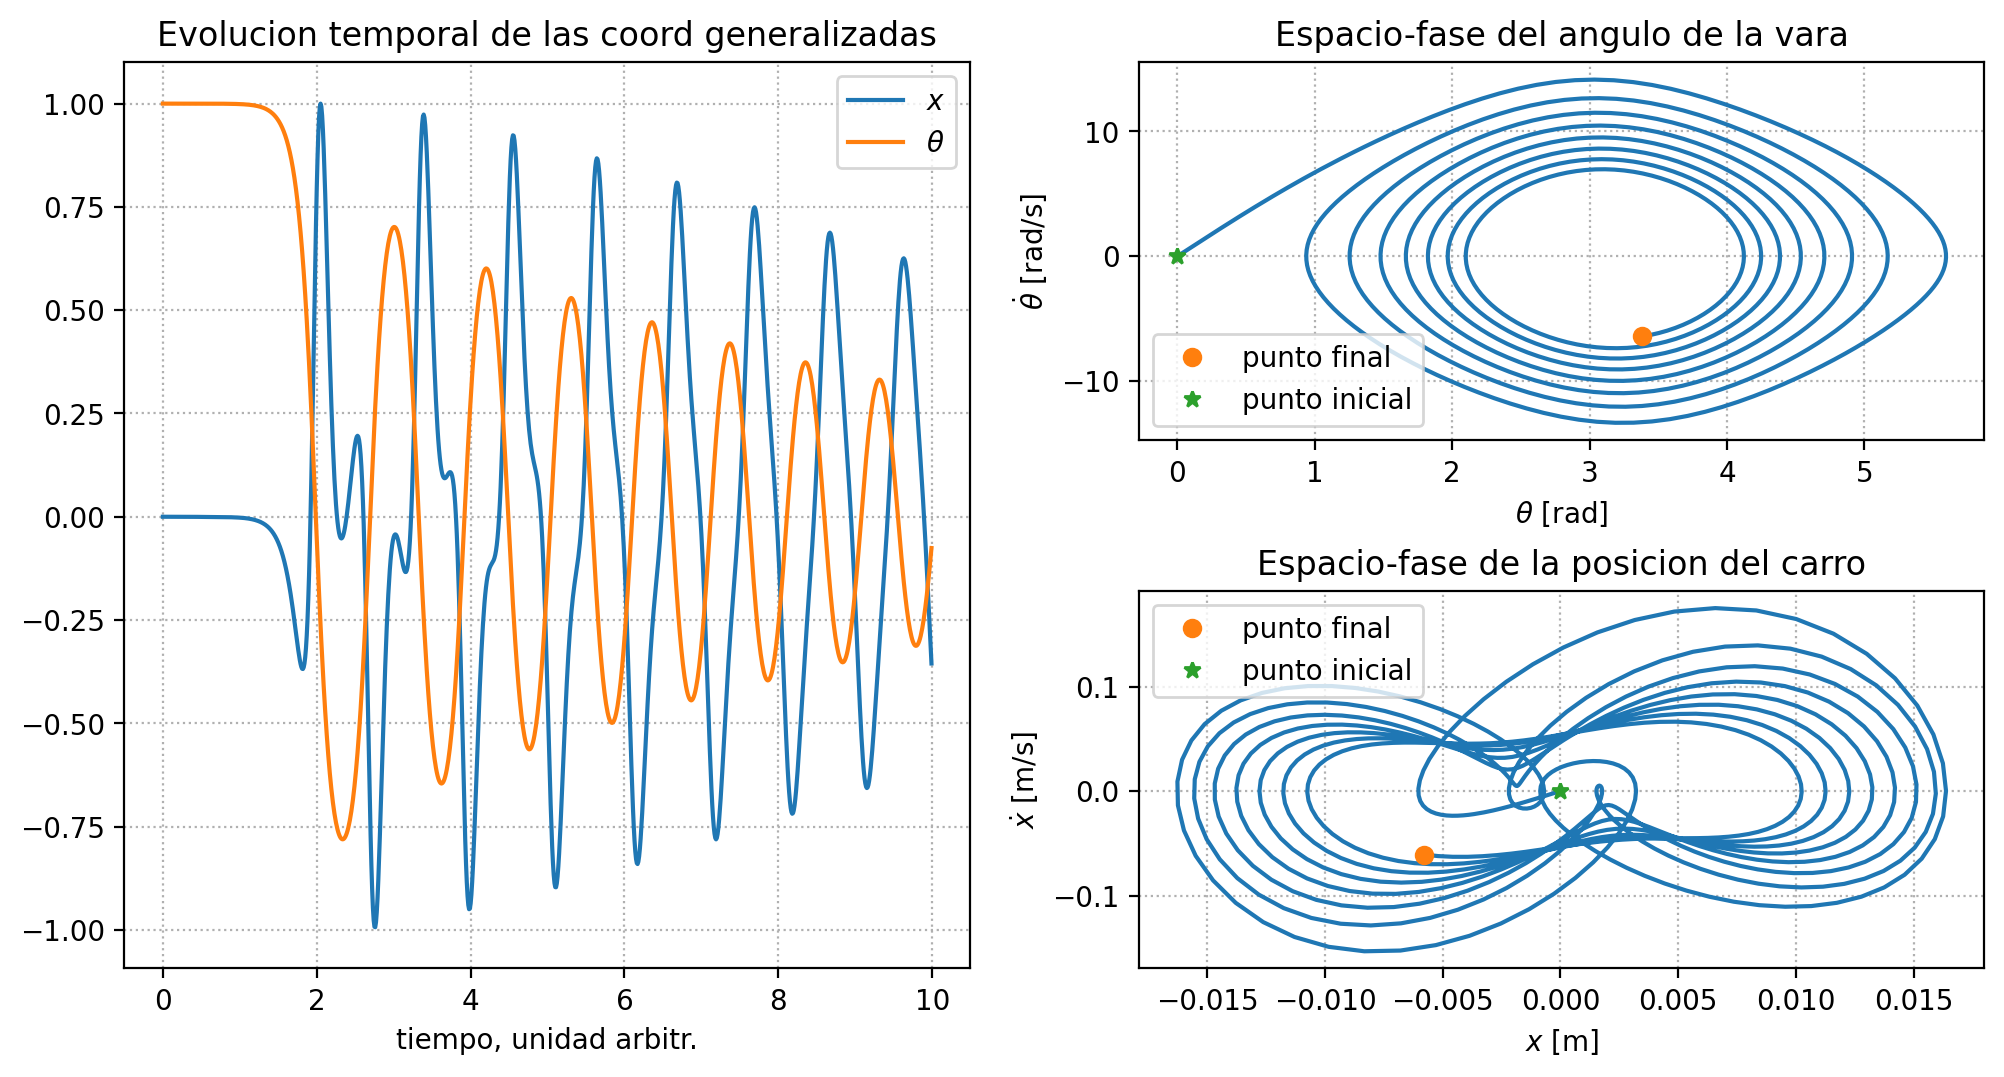

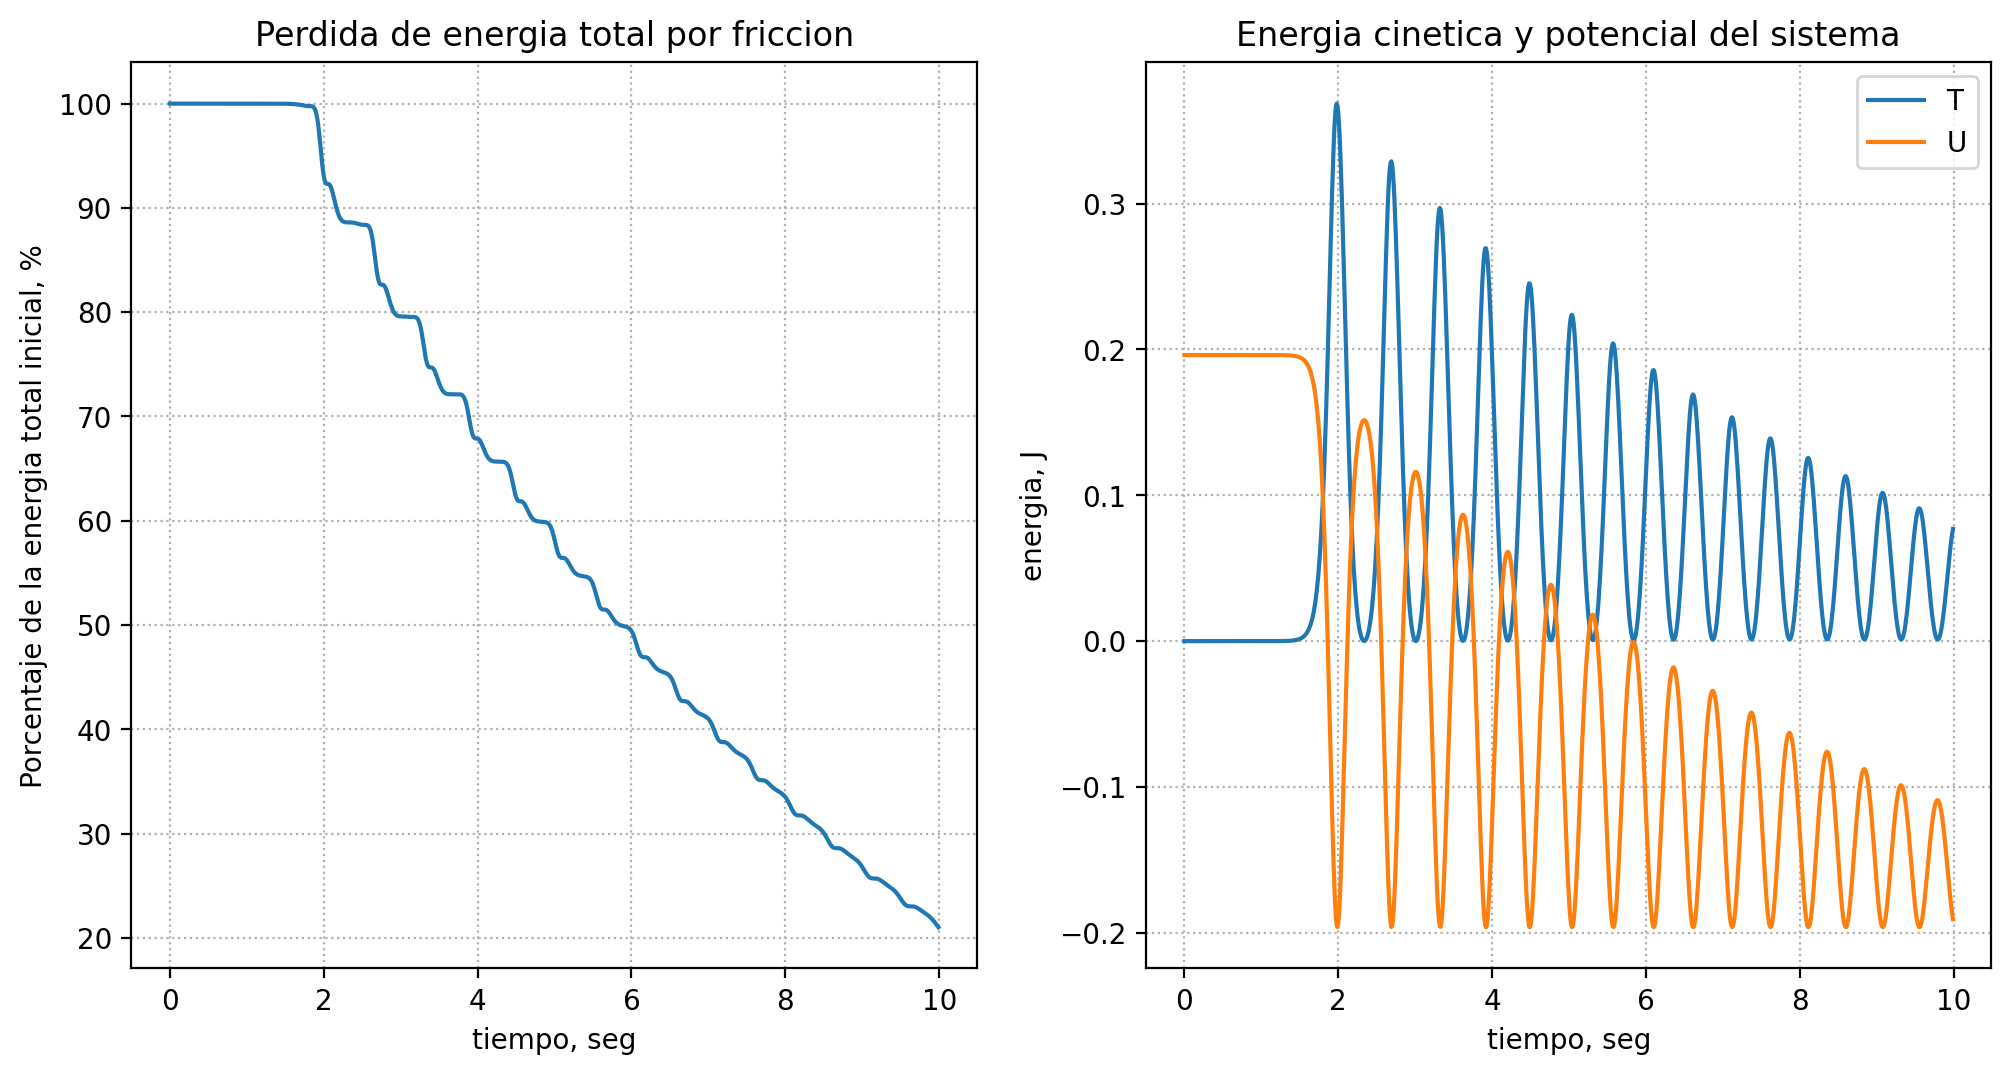

In [37]:
plotData(Z, extForce, energy, appliedForce=False)

El diagrama espacio-fase de $\theta$ revela un movimiento similar al de un péndulo simple con fricción. Hace una espiral hacia una velocidad angular cero y un ángulo $\theta = \pi$. Este punto correspondería al de un péndulo colgando hacia abajo en reposo, que es el resultado intuitivo si no hay fuerzas que intenten mantener la forma invertida. Los dos gráficos inferiores muestran como la energía total del sistema se reduce con el tiempo. Esto es debido a la fuerza de fricción ($\vec{F}$ en [figura 2](#img2)) que actuan en dirección opuesta a la velocidad del carro. Cuanto más grande el coeficiente de fricción $\mu$, mayor la pérdida de energía. Como se ve en los gráficos respecto al tiempo, el péndulo se mantiene invertido algún tiempo antes que el ruido lo de vuelta. Sin embargo, el camino de espacio fase para $q_2(x, \dot{x})$ no muestra un movimiento tan armónico. Parece experimentar una aceleración alta por un tiempo corto, dos veces por cada movimiento periodico. Hagamos una animación para ver mejor lo que sucede. La definición de la función de animación aparece en el [Apendice C](#apndxC). 

In [38]:
generateAnimationWithPhaseSpace(Z, 'falling_phsp.mp4')

Como se ve en la animación, el carro se desliza hacia adelante y hacia atrás debido al péndulo.

Ahora, en nuestra ecuación de estado \eqref{stateEquation} (ecuaciones de movimiento) tenemos la variable $u$ que nos permite ejercer una fuerza externa sobre el carro. En la siguiente parte del notebook la vamos a utilizar para tratar de estabilizar el péndulo. Pero antes, hay que linealizar la ecuación de estado.

## Teoría Parte II
### Linealizando alrededor del equilibrio
Las ecuaciones de movimiento no lineales pueden ser linealizadas a la forma 

\begin{equation}
   \dot{\textbf{x}}
    = \mathcal{A}\textbf{x}  + \mathcal{B}u
\end{equation}

alrededor del equilibrio. El pendulo invertido de nuestro ejemplo tiene dos puntos de equilibrio. El equilibrio estable, que corresponde al péndulo colgando hacia abajo 

\begin{equation}
    \begin{cases} x_0 &= \mathrm{libre} \\
                   x_1 &= \pi  \\
                   x_2 &= 0 \\
                   x_3 &= 0
    \end{cases} . 
\end{equation}

Y el equilibrio inestable, que corresponde al péndulo cuidadosamente balanceado en posición vertical. 

\begin{equation}
    \begin{cases} x_0 &= \mathrm{libre} \\
                   x_1 &= 0  \\
                   x_2 &= 0 \\
                   x_3 &= 0
    \end{cases} . 
\end{equation}

Este último es el punto de equilibrio que nos interesa.

Las matrices $\mathcal{A}$ y $\mathcal{B}$ estan dadas por la matriz jacobiana,

\begin{equation}
\mathcal{J} = \big [ \frac{\partial \textbf{f}}{\partial x_1} \cdots \frac{\partial \textbf{f}}{\partial x_n} \big ] = 
    \begin{bmatrix} \frac{\partial f_0}{\partial x_0} & \cdots & \frac{\partial f_0}{\partial x_n} \\
                    \vdots & \ddots & \vdots \\
                    \frac{\partial f_n}{\partial x_0} & \cdots & \frac{\partial f_n}{\partial x_n}
    \end{bmatrix}
\end{equation}

diferenciado con respecto a las variables  $x$ y $u$, respectivamente [[2]](#rsc). Luego las derivadas se evaluan en el punto de equilibrio. Aquí $f_i$ son las componentes de la ecuación de estado$\eqref{stateEquation}$ 

\begin{equation}
\dot{\textbf{x}} = \frac{d}{dt}
    \begin{bmatrix} x_0 \\
                    x_1 \\
                    x_2 \\
                    x_3
    \end{bmatrix} =
    \begin{bmatrix} f_0 \\
                    f_1 \\
                    f_2 \\
                    f_3
    \end{bmatrix} = 
    \begin{bmatrix} x_2 \\
                    x_3 \\
                    \lambda(x_1)\big[ml^2{x_3}^2\sin x_1 - mgl \sin x_1 \cos x_1 - l\mu x_2 + ul \big] \\
                    \lambda(x_1)\big[(m + M)g \sin x_1 - ml{x_3}^2 \sin x_1 \cos x_1 +  \mu x_2\cos x_1 - u\cos x_1 \big]
    \end{bmatrix} \text{.}
\end{equation}

Al calcular la matriz jacobiana en el punto de equilibrio inestable, cada coordenada excepto $x_0$ se va a cero luego de diferenciar. Esto da 

\begin{equation}
\mathcal{A} = 
    \begin{bmatrix} \frac{\partial f_0}{\partial x_0} \big |_{0} & \frac{\partial f_0}{\partial x_1} \big |_{0} & \frac{\partial f_0}{\partial x_2} \big |_{0} & \frac{\partial f_0}{\partial x_3} \big |_{0} \\
                    \frac{\partial f_1}{\partial x_0} \big |_{0} & \frac{\partial f_1}{\partial x_1} \big |_{0} & \frac{\partial f_1}{\partial x_2} \big |_{0} & \frac{\partial f_1}{\partial x_3} \big |_{0} \\
                    \frac{\partial f_2}{\partial x_0} \big |_{0} & \frac{\partial f_2}{\partial x_1} \big |_{0} & \frac{\partial f_2}{\partial x_2} \big |_{0} & \frac{\partial f_3}{\partial x_3} \big |_{0} \\
                    \frac{\partial f_3}{\partial x_0} \big |_{0} & \frac{\partial f_3}{\partial x_1} \big |_{0} & \frac{\partial f_3}{\partial x_2} \big |_{0} & \frac{\partial f_3}{\partial x_3} \big |_{0} 
    \end{bmatrix} = 
    \begin{bmatrix} 0 & 0 & 1 & 0 \\
                    0 & 0 & 0 & 1 \\
                    0 & \frac{-mg}{M} & \frac{-\mu}{M} & 0 \\
                    0 & \frac{g(m + M)}{lM} & \frac{\mu}{ML} & 0
    \end{bmatrix}
\end{equation}

y

\begin{equation}
\mathcal{B} = 
    \begin{bmatrix} \frac{\partial f_0}{\partial u} \big |_{0} \\
                    \frac{\partial f_1}{\partial u} \big |_{0} \\
                    \frac{\partial f_2}{\partial u} \big |_{0} \\
                    \frac{\partial f_3}{\partial u} \big |_{0}
    \end{bmatrix} = 
    \begin{bmatrix} 0  \\
                    0  \\
                    \frac{1}{M} \\
                    \frac{-1}{Ml}
    \end{bmatrix} \text{.}
\end{equation}

Uno podría realizar una prueba para mostrar que el sistema es controlable con las matrices $\mathcal{A}$ y $\mathcal{B}$, pero en nuestro caso asumiremos que lo es.

Ahora, definiendo el controlador

$$ u = -\mathcal{K}\textbf{x}, $$

obtenemos la forma linealizada 

\begin{equation}
\dot{\textbf{x}} = (\mathcal{A} - \mathcal{BK})\textbf{x},
\label{controller}
\end{equation}

donde $\mathcal{K}$ es la matriz de ganancia. Es una ganancia *proporcional* ya que la variable de control (la fuerza externa $u$) es *proporcional* al vector de estado $\text{bf}$. Esto nos permite elegir un $\mathcal{K}$ tal que los autovalores de la matriz en el paréntesis sean todos estables, en esencia negativos (lo que indica retroalimentación negativa) [[1, 3]](#rsc).

## Implementación Parte II
### Controlador de ganancia proporcional
En esta parte hacemos una implementación similar a la de arriba, además de calcular la matriz de ganancia. Luego, agregando la fuerza de control en cada paso de integración, se crea un lazo de retroalimentación. Para obtener una matriz $\mathcal{K}$ tal que los autovalores de $(\mathcal{A} - \mathcal{BK})$ sean los autovalores deseados `poles`, se usa el paquete de scipy [`signal.place_poles`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.place_poles.html). Este paquete devuelve la matriz de ganancia dados los polos, $\mathcal{A}$ y $\mathcal{B}$.

In [41]:
# Redefiniendo el anguilo inicial de la vara de manera que 
# comience cayendo
x1_0 = 0.2

# Definimos los setpoints. Los valores del  
# vector de estado necesarios para la estabilizacion
# x0 puede ser elegido libremente, elegimos -0.2
setpoints = [-0.2,   
                0,
                0,
                0]

# Definimos las matrices de control A y B
A = np.array([[0, 0, 1, 0],
            [0, 0, 0, 1],
            [0, -m*g/M, -mu/M, 0],
            [0, (m+M)*g/(M*l), mu/(M*l), 0]])
                    
B = np.array([[0], 
            [0], 
            [1/M],
            [-1/(M*l)]])

# Especificando los autovalores deseados de la matriz (A - B*K)
# Subindice PG significa Proportional Gain (Ganancia proporcional en ingles)
poles_PG = [-1.3, -1.4, -1.5, -1.6]
# Obtenemos el estado completo de la retroalimentacion
fsf = signal.place_poles(A, B, poles_PG)
# Extraer la matriz de ganancia
K_PG = fsf.gain_matrix

def controller(z, K):
    """ Dados los valores actuales del vector de estado z
    y la matriz de ganancia K, devuelve el valor de u para control
    """
    offset = z - setpoints
    u = -np.dot(K, offset)
    return u[0]


def integrateControlled(K, pushForce, pushTime):
    """ Este es el proceso de integracion implementado antes,
    pero agregando el termino de control a la fuerza. La posibilidad de 
    empujar (push) el pendulo tambien se considera.
    """
    # Reinicializando matrices
    RHSargs = np.array([m, M, l, g, mu, u_0])
    # Z = [(x0_0, x0_1, ..., x0_n), (x1_0, x1_1, ..., x1_n), (x2, ...,), (x3, ...,)]
    Z = np.zeros((4, n))
    Z[:, 0] = np.array([x0_0, x1_0, x2_0, x3_0])
    # Array con las fuerzas externas a cada paso de tiempo
    extForce = np.zeros((2, n))
    extForce[0, 0] = u_0

    # Inicializar matriz con energia cinetica y potencial del sistema
    energy = np.zeros((2, n))    # energy = [[T_0 ... T_n], [U_0, ... U_n]]
    energy[:, 0] = addEnergy([x0_0, x1_0, x2_0, x3_0])

    #bar = progressbar.ProgressBar()
    for i in ProgressBar(range(n-1)):
        Z[:, i + 1] = RK4Step(Z[:, i], timeStep, RHS, RHSargs)
        
        # "Push"
        #  cambio instantaneo en velocidad angular
        if i == pushTime and i>0:
            Z[3, i + 1] += pushForce
            print("Pushed!")
        
        noise = np.random.uniform(-0.01, 0.01)
        extForce[1, i +1] = noise
        # Calculo de la variable de control
        force = controller(Z[:, i + 1], K)
        # Almacenar la fuerza, u
        extForce[0, i + 1] = force
        # sumando fuerza total y actualziando parametros
        f = noise + force
        RHSargs[5] = f
        # Sumando terminos de energia
        energy[:, i + 1] = addEnergy(Z[:, i + 1])
        
    return Z, extForce, energy

Z_PG, extForce_PG, energy_PG = integrateControlled(K_PG, 0, 0)

LinAlgError: Array must not contain infs or NaNs

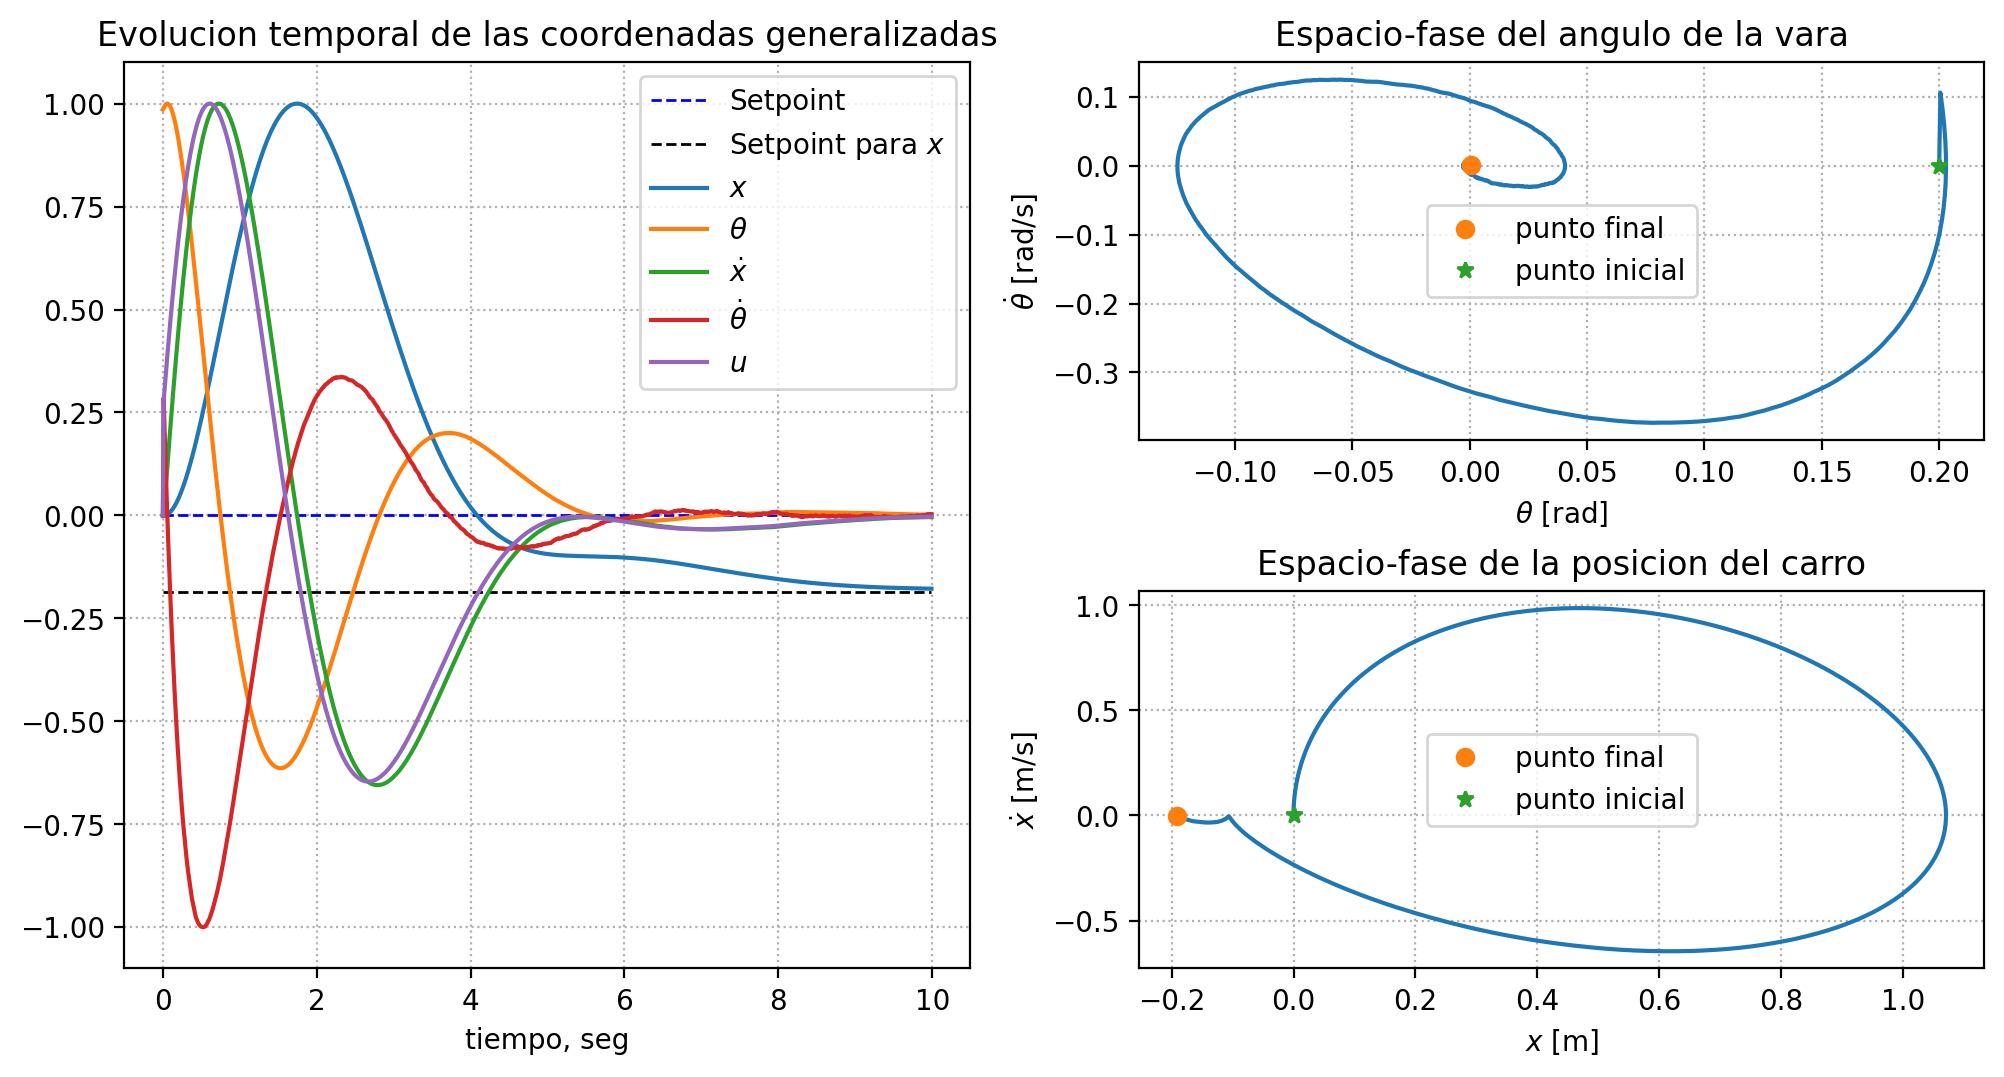

In [42]:
plotData(Z_PG, extForce_PG, energy_PG, appliedForce=True)

Y entonces el péndulo fue balanceado! Los elementos del vector de estado oscilan alrededor de los setpoints antes de la estabilización. Los puntos iniciales están en pendientes positivas en el espacio-fase, lo que indica una posición inicial inestable. En el punto final, la pendiente es negativa (en $\theta = 0$) lo que es posible gracias a la fuerza de control. 

___

<a id="rsc"></a>
## Referencias
<a>[1]</a> Prof. Alan V. Oppenheim, Demostración de clase 26, *Feedback example: The Inverted Pendulum*, del curso de MIT *Signals and Systems*. [Click aquí para las clases](https://ocw.mit.edu/resources/res-6-007-signals-and-systems-spring-2011/lecture-notes/MITRES_6_007S11_lec26.pdf). [Click aquí para un video](https://www.youtube.com/watch?v=D3bblng-Kcc).

<a>[2]</a> Packard, Polo, Horowitz, 2002, [*Jacobien Linearizations, equilibrium points*](https://www.cds.caltech.edu/~murray/courses/cds101/fa02/caltech/pph02-ch19-23.pdf), de Dynamic Systems and feedback. 

<a>[3]</a> Davis, [*9.3. Equilibrium: Stable or Unstable?*](https://web.ma.utexas.edu/users/davis/375/popecol/lec9/equilib.html), Departamento de Matematicas, University of Texas at Austin. 

<a>[4]</a> Prof. Jerrold D. Marsden, [*1 Clase: Mecanica Lagrangiana*](http://www.cds.caltech.edu/archive/help/uploads/wiki/files/212/Mechanics_140a_old.pdf), Caltech, Nov 21 2006. 

___

<a id="apndxA"></a>
## Apéndice A
## Obteniendo las ecuaciones de movimiento

Las ecuaciones corresponden al sistema de la [figura 2](#img2). Como primer paso, encontramos una expresión para la energía cinética y la energía potencial del sistema, $T$ y $U$. Luego, a partir del lagrangiano $L = T - U$, obtenemos las ecuaciones de movimiento usando la ecuación de Euler-Lagrange

\begin{equation}
\frac{d}{dt} \frac{\partial L}{\partial \dot{q}_i} - \frac{\partial L}{\partial q_i} = 0 \text{.}
\label{EL}
\end{equation}

Dado que la vara no tiene masa, la energía cinética del sistema es la suma de la energía cinética de la bolita y el carro,

$$ T = \frac{1}{2}M v^{2}_c + \frac{1}{2}m v^{2}_b .$$

El carro esta fijo en el eje y,

$$ v^2_c = \dot{x}_c^2 + \dot{y}_c^2 = \dot{x}_c^2 .$$

Usando el ángulo de la bolita, $\theta$ relativo al eje y,

\begin{equation}
    \begin{aligned}
        x_b &= x_c + l \sin \theta \\
        y_b &= l\cos \theta \\
        \rightarrow \dot{x}_b &= \dot{x}_c  +\dot{\theta}l \cos \theta \\
        \dot{y}_b &= -\dot{\theta} l \sin \theta \\
        \rightarrow v^2_b &= \dot{x}^2_c + \dot{\theta}^2 l^2 + 2\dot{x}_c \dot{\theta}l \cos \theta
    \end{aligned}
\end{equation}

Así, con la energía potencial

$$ U = mgl\cos \theta ,$$

y reescribiendo $x_c \rightarrow x$, obtenemos el lagrangiano

\begin{equation}
L = \frac{1}{2} \dot{x}^2(m + M) + \frac{1}{2}m\dot{\theta}^2l^2 + m\dot{x}\dot{\theta}l\cos\theta - mgl\cos\theta
\label{L}
\end{equation}

Aplicando \eqref{EL} a las coordenadas generalizadas $q_i = \theta$, tenemos

\begin{equation}
\ddot{\theta} = \frac{g}{l}\sin\theta - \frac{\ddot{x}}{l}\cos\theta .
\label{I}
\end{equation}

La segunda coordenada generalizada $q_i = x$ está involucrada en la fuerza externa $u$ y la fuerza de fricción disipativa. Entonces, la ecuación de Euler-Lagrange se ve reemplazada por el principio de Lagrange-d'Alambert, que es equivalente a las ecuaciones de Euler-Lagrange con fuerza externa [[6]](#rsc):

\begin{equation}
\frac{d}{dt} \frac{\partial L}{\partial \dot{q}_i} - \frac{\partial L}{\partial q_i} = F_{ext}(q, \dot{q}) \text{.}
\label{ELEF}
\end{equation}

Esto da la ecuación de movimiento

\begin{equation}
\ddot{x} = \frac{1}{m+M}\big [ ml\big(\dot{\theta}^2\sin\theta - \ddot{\theta}\cos\theta\big) - \mu\dot{x} + u \big ],
\label{II}
\end{equation}

donde $-\mu\dot{x}$ es una aproximación a la fuerza de fricción en el sistema ($\mu$ es el coeficiente de fricción), y $u$ es la fuerza externa aplicada al carrito.

Reescribiendo \eqref{I} y \eqref{II} en forma matricial

\begin{equation}
    \begin{bmatrix} m+M & ml\cos\theta \\
                    \cos\theta & l 
    \end{bmatrix}
    \begin{bmatrix} \ddot{x} \\
                    \ddot{\theta}
    \end{bmatrix} = 
    \begin{bmatrix} ml\dot{\theta}^2\sin\theta - \mu\dot{x} \\
                    g\sin\theta
    \end{bmatrix} + 
    \begin{bmatrix} 1 \\
                    0
    \end{bmatrix} u .
\end{equation}

Definiendo

\begin{equation}
    \Lambda(\theta) =
    \begin{bmatrix} m+M & ml\cos\theta \\
                    \cos\theta & l 
    \end{bmatrix}
\end{equation}

las ecuaciones de movimiento resultan 

\begin{equation}
    \begin{bmatrix} \ddot{x} \\
                    \ddot{\theta}
    \end{bmatrix} = \Lambda(\theta)^{-1}
    \begin{bmatrix} ml\dot{\theta}^2\sin\theta - \mu\dot{x} \\
                    g\sin\theta
    \end{bmatrix} + 
    \begin{bmatrix} 1 \\
                    0
    \end{bmatrix} u ,
\label{EQM}
\end{equation}

donde $\Lambda(\theta)^{-1}$ es la inversa de $\Lambda(\theta)$,

\begin{equation}
\Lambda(\theta)^{-1} = \frac{1}{l(M+m\sin^2\theta)}
    \begin{bmatrix} l & -ml\cos\theta \\
                    -\cos\theta & m+M
    \end{bmatrix}.
\end{equation}



<a id="apndxB"></a>
## Apéndice B - Definicion de `plotData`

In [29]:
def relative(data):
    """Devuelve los valores de 'data' relativos al maximo de 'data' en valor absoluto."""
    return data/np.amax(np.absolute(data))
        
        
def angle(data):
    """Mapea los datos de 'data' al intervalo [1, -1]"""
    copy = np.zeros(data.shape)
    for i in range(len(data)):
        if data[i] <= np.pi:
            copy[i] = (np.pi - data[i])/np.pi
        else:
            copy[i] = -(data[i] - np.pi)/np.pi
    return copy

In [30]:
def plotData(Z, extForce, energy, appliedForce):
        """ Esta funcion plotea los resultados en evolucion temporal, y espacio de fase.
        Difiere entre dos funcionalidades dependiendo del valor booleano de 'appliedForce'.
        Argumentos:
                Z              4xN array. El vector de estado con valores de componentes en cada paso
                extForce       2xN array. El valor externo de fuerza y ruido en cada paso
                energy         2xN array. La energia cinetica y potencial en cada paso
                appliedForce   booleano.
        """
        # Definimos un array del tiempo en seg para cada paso
        time = np.arange(0, n*timeStep, timeStep)
        totalF = extForce[0] + extForce[1]
        
        # Si es TRUE, Plotea la evolucion temporal de la F externa y cada vector de componentes
        if appliedForce:
            plt.figure(figsize=(12, 6), dpi=200)
            plt.subplot(2, 2, (1, 3))
            plt.title("Evolucion temporal de las coordenadas generalizadas")
            plt.plot(time, np.zeros(n), 'b--',label='Setpoint', linewidth=1)
            plt.plot(time, [setpoints[0]/np.amax(np.absolute(Z[0])) for i in range(n)], 
                     '--', color="black", linewidth=1, label=r"Setpoint para $x$")
            plt.plot(time, relative(Z[0]), label=r'$x$')
            plt.plot(time, relative(Z[1]), label=r"$\theta$")
            plt.plot(time, relative(Z[2]), label=r"$\dot{x}$")
            plt.plot(time, relative(Z[3]), label=r"$\dot{\theta}$")
            plt.plot(time, relative(extForce[0]), label=r"$u$")
            plt.xlabel('tiempo, seg')
            plt.legend(loc='best')
            plt.grid(linestyle=':')
        # Plotea la evolucion temporal de la pos del carro y el angulo de la vara si appliedForce == false.
        else:
            plt.figure(figsize=(12, 6), dpi=200)
            plt.subplot(2, 2, (1, 3))
            plt.title("Evolucion temporal de las coord generalizadas")
            plt.plot(time, relative(Z[0]), label=r'$x$')
            plt.plot(time, angle(Z[1]), label=r"$\theta$")
            plt.xlabel('tiempo, unidad arbitr.')
            plt.legend(loc='best')
            plt.grid(linestyle=':')
        
        # Independiente de appliedForce.
        # Genera diagrama de espacio de fase de la coord theta.
        plt.subplot(222)
        plt.title("Espacio-fase del angulo de la vara")
        plt.plot(Z[1], Z[3])
        plt.plot(Z[1][-1], Z[3][-1], 'o', label="punto final")
        plt.plot(Z[1][0], Z[3][0], '*', label="punto inicial")
        plt.xlabel(r'$\theta$ [rad]')
        plt.ylabel(r'$\dot{\theta}$ [rad/s]')
        plt.legend(loc='best')
        plt.grid(linestyle=":")
        
        # Genera diagrama de espacio de fase de la coord x.
        plt.subplot(224)
        plt.title("Espacio-fase de la posicion del carro")
        plt.plot(Z[0], Z[2])
        plt.plot(Z[0][-1], Z[2][-1], 'o', label="punto final")
        plt.plot(Z[0][0], Z[2][0], '*', label="punto inicial")
        plt.xlabel(r'$x$ [m]')
        plt.ylabel(r'$\dot{x}$ [m/s]')
        plt.legend(loc='best')
        plt.grid(linestyle=":")
        
        # Ajusta separacion horizontal entre graficos
        plt.subplots_adjust(hspace=0.4)
        
        if appliedForce == False:
            # Plotea la perdida de energia total como funcion del tiempo
            plt.figure(figsize=(12, 6), dpi=200)
            plt.subplot(121)
            plt.title("Perdida de energia total por friccion")
            # Energia total minima del sistema
            minima = m*g*l*np.cos(np.pi)
            # En eje y, porcentaje de energia relativa a la total inicial
            plt.plot(time, (np.sum(energy, 0) - minima)/(np.sum(energy[:,0], 0) - minima)*100)
            plt.xlabel("tiempo, seg")
            plt.ylabel('Porcentaje de la energia total inicial, %')
            plt.grid(linestyle=":")
            
            # Grafica energia cinetica y potencial del sistema en funcion del tiempo.
            plt.subplot(122)
            plt.title("Energia cinetica y potencial del sistema")
            plt.xlabel("tiempo, seg")
            plt.ylabel("energia, J")
            plt.plot(time, energy[0], label="T")
            plt.plot(time, energy[1], label="U")
            plt.legend(loc='best')
            plt.grid(linestyle=":")

        plt.show()

<a id="apndxC"></a>
## Apéndice C - Definición de `generateAnimation` y
## `generateAnimationWithPhaseSpace`

In [31]:
def cartX(x_1):
    """ Dados los valores de x_1, la pos del carro,
    devuelve las coordenadas x de las esquinas del
    carro."""
    return np.array([x_1 - l/8, x_1 + l/8, x_1 + l/8, x_1 - l/8, x_1 - l/8])

In [32]:
def generateAnimation(Z, Z2, name):
    """ Esta funcion genera dos animaciones del sistema como funcion del tiempo,
    a partir de dos resultados, 'Z' y 'Z2'. Se grafican una anim debajo de la otra.
    Argumentos:
            Z      4xN array. Valores del vec de estado a cada paso
            Z2     4xN array. Valores del vec de estado a cada paso
            name   string. Nombre del archivo de animacion
    """
    
    # Definimos un array con el tiempo en seg para cada paso
    timeValues = np.arange(0, n*timeStep, timeStep)
    
    X = Z[0] + l*np.sin(Z[1])                           # x coord de la bola
    Y = l*np.cos(Z[1])                                  # y coord de la bola
    cartY = np.array([l/16, l/16, -l/16, -l/16, l/16])  # y coord de las esquinas del carro
    
    X2 = Z2[0] + l*np.sin(Z2[1])                           # x coord de la bola 2
    Y2 = l*np.cos(Z2[1])                                   # y coord de la bola 2
    cartY2 = np.array([l/16, l/16, -l/16, -l/16, l/16])    # y coord de las esquinas del carro 2
    
    fig = plt.figure(figsize=(figSizeX, figSizeY), dpi=200)
    
    # Animacion/resultado/pendulo uno
    plt.subplot(211)
    # Limites ejes
    xMin = np.min(X) - 1.5*l
    xMax = np.max(X) + 1.5*l
    # Ajuste de limites y para evitar deformaciones 
    # para que no haya escalamientos raros
    xDomain = xMax - xMin
    yDomain = xDomain * 0.5*figSizeY/figSizeX
    plt.xlim(xMin, xMax)
    plt.ylim(-0.5*yDomain, 0.5*yDomain)

    # Definimos los diferentes elementos en la animacion
    surface, = plt.plot([xMin, xMax], [-l/16, -l/16], color='black', linewidth=1)    # La superficie
    tail, = plt.plot(X[0], Y[0], '--', color="blue")            # Posicion previa de la bola
    cart, = plt.plot(cartX(Z[0, 0]), cartY, color="red")        # Carro
    rod, = plt.plot([Z[0, 0], X[0]], [0, Y[0]], color="black")  # la vara de longitud l sin masa
    bead, = plt.plot(X[0], Y[0], 'o', color="black", ms=4)      # la bola del pendulo
    text = plt.text(xMax-0.1, 0.5*yDomain - 0.1, r'$t =  %.2f$s'%(timeValues[0]), # Caja de texto con tiempo transcurrido
            {'color': 'k', 'fontsize': 10, 'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle='round', fc='w', ec='k', pad=0.2)})

    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.title("Controlador de ganancia proporcional")
    
    # Animacion/resultado/pendulo dos
    plt.subplot(212)
    # Limites ejes
    xMin2 = np.min(X2) - 3*l 
    xMax2 = np.max(X2) + 3*l 
    xDomain2 = xMax2 - xMin2
    yDomain2 = xDomain2 * 0.5*figSizeY/figSizeX
    plt.xlim(xMin2, xMax2)
    plt.ylim(-0.5*yDomain2, 0.5*yDomain2)

    # Definimos los diferentes elementos en la animacion
    surface2, = plt.plot([xMin2, xMax2], [-l/16, -l/16], color='black', linewidth=1)    # La superficie
    tail2, = plt.plot(X2[0], Y2[0], '--', color="blue")              # Posicion previa de la bola
    cart2, = plt.plot(cartX(Z2[0, 0]), cartY2, color="red")         # Carro
    rod2, = plt.plot([Z2[0, 0], X2[0]], [0, Y2[0]], color="black")   # la vara de longitud l sin masa
    bead2, = plt.plot(X2[0], Y2[0], 'o', color="black", ms=4)        # la bola del pendulo
    text2 = plt.text(xMax2-0.1, 0.5*yDomain2 - 0.1, r'$t =  %.2f$s'%(timeValues[0]), # Caja de texto con tiempo transcurrido
            {'color': 'k', 'fontsize': 10, 'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle='round', fc='w', ec='k', pad=0.2)})

    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.title("Regulador cuadrático lineal")
    
    plt.subplots_adjust(hspace=0.3)
    
    # Calculo del numero de cuadros
    FPS = 30
    framesNum = int(FPS*duration)
    dataPointsPerFrame = int(n/framesNum)

    # Funcion animacion. Se la llama secuencialmente
    def animate(j):
        time = j*dataPointsPerFrame
        # Pendulo 1
        tail.set_xdata(X[:time])
        tail.set_ydata(Y[:time])
        cart.set_xdata(cartX(Z[0, time])) 
        cart.set_ydata(cartY)
        rod.set_xdata([Z[0, time], X[time]])
        rod.set_ydata([0, Y[time]])
        bead.set_xdata(X[time])
        bead.set_ydata(Y[time])
        text.set_text(r'$t =  %.2f$s'%(timeValues[time]))
        
        # Pendulo 2
        tail2.set_xdata(X2[:time])
        tail2.set_ydata(Y2[:time])
        cart2.set_xdata(cartX(Z2[0, time])) 
        cart2.set_ydata(cartY2)
        rod2.set_xdata([Z2[0, time], X2[time]])
        rod2.set_ydata([0, Y2[time]])
        bead2.set_xdata(X2[time])
        bead2.set_ydata(Y2[time])
        text2.set_text(r'$t =  %.2f$s'%(timeValues[time]))

    # Crear animacion
    anim = animation.FuncAnimation(fig, animate, frames=framesNum)

    # Guardar animacion.
    # Si falla, probar usar otro codec 
    # (ffmpeg, mencoder, imagemagick), u otra extension
    # (.mp4, .gif, .ogg, .ogv, .avi etc.). 
    anim.save(name, writer='pillow', fps=FPS)

    # Cerrar grafico
    plt.close(anim._fig)

    # Mostrar la animacion
    with open(name, 'rb') as file:
        display(Image(file.read()))

In [33]:
def generateAnimationWithPhaseSpace(Z, name):
    """ Esta funcion genera una animacion que consiste en un grafico de un pendulo
    y grafico del espacio-fase de las dos coordenadas generalizadas x y theta, como
    funcion del tiempo.
    Argumentos:
            Z      4xN array. Valores de componente del vector de estado a cada paso
            name   string. Nombre del archivo de animacion
    """
    
    X = Z[0] + l*np.sin(Z[1])                           # x  coord de la bola
    Y = l*np.cos(Z[1])                                  # y coord de la bola
    cartY = np.array([l/16, l/16, -l/16, -l/16, l/16])  # y coord de las esquinas del carro

    fig = plt.figure(figsize=(figSizeX, figSizeY), dpi=200)
    # Limites de los ejes
    plt.subplot(2, 2, (1, 3))
    xMin = np.min(X) - l/2 
    xMax = np.max(X) + l/2
    # Ajuste de limites y para evitar deformaciones 
    # para que no haya escalamientos raros
    xDomain = xMax - xMin
    yDomain = xDomain*2*figSizeY/figSizeX
    plt.xlim(xMin, xMax)
    plt.ylim(-0.5*yDomain, 0.5*yDomain)

    # Definimos los diferentes elementos de la animacion
    surface, = plt.plot([xMin, xMax], [-l/16, -l/16], color='black', linewidth=1)    # La superficie
    tail, = plt.plot(X[0], Y[0], '--', color="blue")            # Posicion previa de la bola
    cart, = plt.plot(cartX(Z[0, 0]), cartY, color="red")        # carro 
    rod, = plt.plot([Z[0, 0], X[0]], [0, Y[0]], color="black")  # vara de longitud l
    bead, = plt.plot(X[0], Y[0], 'o', color="black", ms=4)      # la bola del pendulo

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Pendulo invertido en un carro")
    
    # Grafico espacio-fase del angulo theta de la vara
    plt.subplot(222)
    plt.title("Angulo de la vara en espacio fase")
    anglePath, = plt.plot(Z[1], Z[3])
    angleFinal, = plt.plot(Z[1, -1], Z[3, -1], 'o', label="Punto final")
    angleCurrent, = plt.plot(Z[1, 0], Z[3, 0], '*', label="Punto actual")
    plt.xlabel(r'$\theta$ [rad]')
    plt.ylabel(r'$\dot{\theta}$ [rad/s]')
    plt.legend(loc='best')
    plt.grid(linestyle=":")
    
    # espacio fase de la posicion x del carro
    plt.subplot(224)
    plt.title("Posicion del carro en espacio-fase")
    cartPath, = plt.plot(Z[0], Z[2])
    cartFinal, = plt.plot(Z[0, -1], Z[2, -1], 'o', label="Punto final")
    cartCurrent, = plt.plot(Z[0, 0], Z[2, 0], '*', label="Punto actual")
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$\dot{x}$ [m/s]')
    plt.legend(loc='best')
    plt.grid(linestyle=":")    
    
    # Calculo del numero de cuadros
    FPS = 30
    framesNum = int(FPS*duration)
    dataPointsPerFrame = int(n/framesNum)

    # Funcion animacion a llamar secuencialmente
    def animate(j):
        time = j*dataPointsPerFrame
        
        # Actualizando cada elemento a cada tiempo
        tail.set_xdata(X[:time])
        tail.set_ydata(Y[:time])
        cart.set_xdata(cartX(Z[0, time])) 
        cart.set_ydata(cartY)
        rod.set_xdata([Z[0, time], X[time]])
        rod.set_ydata([0, Y[time]])
        bead.set_xdata(X[time])
        bead.set_ydata(Y[time])
        
        angleCurrent.set_xdata(Z[1, time])
        angleCurrent.set_ydata(Z[3, time])
        anglePath.set_xdata(Z[1, :time])
        anglePath.set_ydata(Z[3, :time])
        cartCurrent.set_xdata(Z[0, time])
        cartCurrent.set_ydata(Z[2, time])
        cartPath.set_xdata(Z[0, :time])
        cartPath.set_ydata(Z[2, :time])

    # Crear animacion
    anim = animation.FuncAnimation(fig, animate, frames=framesNum)

    # Guardar animacion.
    # Si falla, probar usar otro codec 
    # (ffmpeg, mencoder, imagemagick), u otra extension
    # (.mp4, .gif, .ogg, .ogv, .avi etc.).
    anim.save(name, writer='ffmpeg', fps=FPS)

    # Cerrar grafico
    plt.close(anim._fig)

    # Mostrar la animacion
    with open(name, 'rb') as file:
        display(Image(file.read()))